In [233]:
%matplotlib inline

In [249]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold, train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.externals.six.moves import zip
import matplotlib.pyplot as plt

In [235]:
X_array = np.load('outputMatrix_userTrimmed.npz')
X = X_array['matrix']

In [236]:
# remove features with low variance (ie more than 80% samples have same value)
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_sel = sel.fit_transform(X)
X_sel.shape

(3047, 2838)

In [ ]:
# alternative: PCA for dimensionality reduction
#sel = PCA()
#pca = sel.fit(X)
#print pca.explained_variance_ratio_
#X_sel = sel.fit_transform(X)

In [237]:
y_array = np.load('user_class_array.npz')
y_np = y_array['matrix']
y = y_np.tolist()[0]

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.1,
                                                    random_state=9)

In [185]:
dt = DecisionTreeClassifier(max_depth=3, splitter='random', max_features=1)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.38360655737704918

In [239]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, splitter='random', max_features=1),
                        n_estimators=10000,
                        learning_rate=1.5)

In [240]:
bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=1, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random'),
          learning_rate=1.5, n_estimators=10000, random_state=None)

In [241]:
test_errors = []

for test_predict in bdt.staged_predict(X_test):
    test_errors.append(1. - accuracy_score(test_predict, y_test))
    
n_trees = len(bdt)

In [242]:
estimator_errors = bdt.estimator_errors_[:n_trees]
estimator_weights = bdt.estimator_weights_[:n_trees]

In [243]:
min(estimator_errors), 1-min(test_errors)

(2.5086239311516713e-05, 0.62295081967213117)

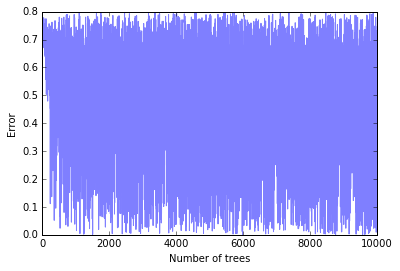

In [244]:
plt.plot(range(1, n_trees + 1), estimator_errors, 'b', alpha=0.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of trees')

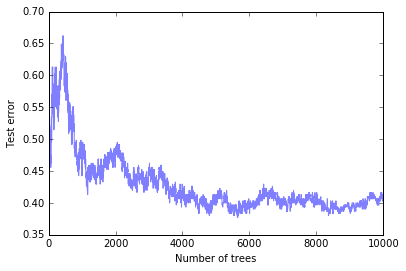

In [245]:
plt.plot(range(1, n_trees + 1), test_errors, 'b', alpha=0.5)
plt.legend()
plt.ylabel('Test error')
plt.xlabel('Number of trees')

In [246]:
bdt.score(X_test, y_test)

0.5901639344262295

In [251]:
y_test_vect = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_pred = bdt.predict(X_test)
y_pred_vect = label_binarize(y_pred, classes=[0, 1, 2, 3, 4])
roc_scores = roc_auc_score(y_test_vect, y_pred_vect, average='micro')
roc_scores

0.7438524590163933

In [216]:
# max_depth=2, accuracy=0.584, auc=0.624, n_estimators=8000
# max_depth=2, accuracy=0.577, auc=0.635, n_estimators=10000
# max_depth=3, accuracy=0.642, auc=0.633, n_estimators=8000
#### max_depth=3, accuracy=0.636, auc=0.648, n_estimators=10000

In [226]:
zeror_pred = np.zeros((len(y_test), 5))
for i in range(zeror_pred.shape[0]):
    zeror_pred[i][4] = 1

In [232]:
zeror_roc = roc_auc_score(y_test_vect, zeror_pred, average='micro')
zeror_roc

0.6045081967213114